# Performance analysis
This notebook is create to compare the performance of different algorithms for graphical inference, namely graphical lasso (GL or GLASSO), latent graph lasso (LVGLASSO), time-varying graphical lasso (TVGL) wuth our method, latent variable time-varying graphical lasso (LVGL).

## Before proceeding
Other methods are not necessarily implemented in Python. Therefore, this is a list of required steps in order to successfully install the code.

### Install instructions for
#### 1a. GL (scikit-learn implementation)
For this, it is not required to do anything, as `sklearn` should be already installed in your system as it is a dependency of `regain`. Otherwise, install it as first thing with 
```
conda install scikit-learn
```
or 
```
pip install scikit-learn
```

#### 1b. GLASSO (R implementation)
This is the R implementation for graphical lasso, called GLASSO. It is available as an R package, thus requiring R installed in your system. Then, in R console (simply call `R` from a command line):
```R
install.packages("glasso")
```
Refer to [GLASSO documentation](https://cran.r-project.org/web/packages/glasso/glasso.pdf) for further information.

#### 2. LVGLASSO (Matlab implementation)
This requires to have [Matlab installed](https://it.mathworks.com/help/install/ug/install-mathworks-software.html) (version2016b or higher) and [Matlab engine for Python](https://it.mathworks.com/help/matlab/matlab_external/install-the-matlab-engine-for-python.html).
Then, [download the code](https://www.math.ucdavis.edu/~sqma/ADMM-LVGLasso) and unpack the folder.
Ensure to have a file called `ADMM_B.m`. Save the location of the code, as it will be necessary to call the `ADMM_B.m` script.

**NOTE:** There is a so-called [LVGLASSO in the R packages](https://www.rdocumentation.org/packages/lvnet/versions/0.3.2/topics/lvglasso). Note that THIS IS NOT RIGHT, as it is implemented in a different way and it requires to specify a priori the number of latent variables. See the link above for further details.

**NOTE 2:** Our `regain` package has a Python wrapper that ease the calling of such Matlab functions. Therefore, conversions of numpy arrays to Matlab matrices are done under the hood from the script `regain/wrappers/lvglasso/LVGLASSO.m`.

#### 3. TVGL (Python implementation)
Since it is a Python implementation, this does not require additional software (beside having `git` installed). However, there is a little modification in the source code to do in order to obtain additional results, such as the number of iterations and the estimated covariance matrices.

1. Clone the repo (https://github.com/davidhallac/TVGL) in a folder, with
```bash
git clone https://github.com/davidhallac/TVGL.git
```
Its requirements are [`cvxpy`](http://www.cvxpy.org/en/latest/install/index.html) and [`snap`](https://snap.stanford.edu/snappy/) installed. 

2. Modify the line 76 of ./TVGL/TVGL.py (ie, `return thetaSet`) with 
```
return thetaSet, empCovSet, gvx.status, gvx
```
3. Add after the line 454 of ./TVGL/inferGraphL2.py (and other norms if required)
```
self.n_iter_ = num_iterations
```

#### 4. REGAIN
Of course, first of all you should download and install the `regain` package (our method). If you haven't done it yet, do it now!

```
conda install -c fdtomasi regain
```
or
```
pip install regain
```

Or, you have the source code, `mv` to the `regain` folder, then
```
python setup.py install
```

and that's it. Now you are good to go!

In [1]:
%matplotlib inline
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
import matlab.engine
import matlab
import pandas as pd

from itertools import product
from scipy.io import loadmat
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.datasets.base import Bunch
from sklearn.utils.extmath import squared_norm
from sklearn.covariance import empirical_covariance
from sklearn.model_selection import GridSearchCV, ShuffleSplit

from regain import datasets; reload(datasets)
from regain import prox; reload(prox)
from regain.admm import graph_lasso_; reload(graph_lasso_);
from regain.admm import time_graph_lasso_; reload(time_graph_lasso_);
from regain.admm import latent_graph_lasso_; reload(latent_graph_lasso_);
from regain.admm import latent_time_graph_lasso_; reload(latent_time_graph_lasso_);
from regain import utils; reload(utils)
import time

# Performances of the different algorithms

In [344]:
def gl_results(data_grid, K, K_obs, ells, **params):
    
    mdl = graph_lasso_.GraphLasso(
        assume_centered=0, verbose=0, rtol=1e-5, tol=1e-5,
        max_iter=500, rho=1./ np.sqrt(data_grid.shape[0]))
    
    tic = time.time()
    iters = []
    precisions = []
    for d in data_grid.transpose(2,0,1):
        mdl.set_params(**params).fit(d)
        iters.append(mdl.n_iter_)
        precisions.append(mdl.precision_)
    tac = time.time()
    iterations = np.max(iters)
    precisions = np.array(precisions)

    F1score = utils.structure_error(K, precisions)['f1']
    MSE_observed = None # utils.error_norm(K_obs, precisions - latents)
    MSE_precision = utils.error_norm(K, precisions)
    MSE_latent = None#utils.error_norm(ells, latents)
    mean_rank_error = None#utils.error_rank(ells, latents)
    
    res = dict(n_dim_obs=K.shape[1],
               time=tac-tic,
               iterations=iterations,
               F1score=F1score,
               MSE_precision=MSE_precision,
               MSE_observed=MSE_observed,
               MSE_latent=MSE_latent,
               mean_rank_error=mean_rank_error,
               note=None,
               estimator=mdl)
    return res

def lgl_results(data_grid, K, K_obs, ells, **params):
    
    mdl = latent_graph_lasso_.LatentGraphLasso(
        assume_centered=0, verbose=0, rtol=1e-5, tol=1e-5,
        max_iter=500, rho=1./ np.sqrt(data_grid.shape[0]))
    
    tic = time.time()
    iters = []
    precisions, latents = [], []
    for d in data_grid.transpose(2,0,1):
        mdl.set_params(**params).fit(d)
        iters.append(mdl.n_iter_)
        precisions.append(mdl.precision_)
        latents.append(mdl.latent_)
    tac = time.time()
    iterations = np.max(iters)
    precisions = np.array(precisions)
    latents = np.array(latents)

    F1score = utils.structure_error(K, precisions)['f1']
    MSE_observed = utils.error_norm(K_obs, precisions - latents)
    MSE_precision = utils.error_norm(K, precisions)
    MSE_latent = utils.error_norm(ells, latents)
    mean_rank_error = utils.error_rank(ells, latents)
    
    res = dict(n_dim_obs=K.shape[1],
               time=tac-tic,
               iterations=iterations,
               F1score=F1score,
               MSE_precision=MSE_precision,
               MSE_observed=MSE_observed,
               MSE_latent=MSE_latent,
               mean_rank_error=mean_rank_error,
               note=None,
               estimator=mdl)
    return res

def tgl_results(data_grid, K, K_obs, ells, **params):
    
    mdl = time_graph_lasso_.TimeGraphLasso(
        bypass_transpose=False, assume_centered=0, verbose=0, rtol=1e-5, tol=1e-5,
        max_iter=500, rho=1./ np.sqrt(data_grid.shape[0]))
    
    tic = time.time()
    ll = mdl.set_params(**params).fit(data_grid)
    tac = time.time()
    iterations = ll.n_iter_
    F1score = utils.structure_error(K, ll.precision_)['f1']
    MSE_observed = None # utils.error_norm(K_obs, ll.precision_ - ll.latent_)
    MSE_precision = utils.error_norm(K, ll.precision_)
    MSE_latent = None # utils.error_norm(ells, ll.latent_)
    mean_rank_error = None # utils.error_rank(ells, ll.latent_)
    
    res = dict(n_dim_obs=K.shape[1],
               time=tac-tic,
               iterations=iterations,
               F1score=F1score,
               MSE_precision=MSE_precision,
               MSE_observed=MSE_observed,
               MSE_latent=MSE_latent,
               mean_rank_error=mean_rank_error,
               note=None,
               estimator=ll)
    return res

reload(latent_time_graph_lasso_)
reload(utils)

def ltgl_results(data_grid, K, K_obs, ells, **params):
    
    reload(latent_time_graph_lasso_)
    mdl = latent_time_graph_lasso_.LatentTimeGraphLasso(
        bypass_transpose=False, assume_centered=0, verbose=0, rtol=1e-5, tol=1e-5,
        max_iter=1000, rho=1./ np.sqrt(data_grid.shape[0]), update_rho_options=dict(mu=5))
    
    tic = time.time()
    ll = mdl.set_params(**params).fit(data_grid)
    tac = time.time()
    iterations = ll.n_iter_
    ss = utils.structure_error(K, ll.precision_)#, thresholding=1, eps=1e-5)
    MSE_observed = utils.error_norm(K_obs, ll.precision_ - ll.latent_)
    MSE_precision = utils.error_norm(K, ll.precision_)
    MSE_latent = utils.error_norm(ells, ll.latent_)
    mean_rank_error = utils.error_rank(ells, ll.latent_)
    
    res = dict(n_dim_obs=K.shape[1],
               time=tac-tic,
               iterations=iterations,
               MSE_precision=MSE_precision,
               MSE_observed=MSE_observed,
               MSE_latent=MSE_latent,
               mean_rank_error=mean_rank_error,
               note=None,
               estimator=ll,
              latent=ll.latent_)
    
    res = dict(res, **ss)
    return res  

In [3]:
from sklearn.covariance import GraphLasso
def glasso_results(data_grid, K, K_obs, ells, alpha):
    gl = GraphLasso(alpha=alpha, mode='cd', assume_centered=False, max_iter=500)
    
    tic = time.time()
    iters = []
    precisions = []
    for d in data_grid.transpose(2,0,1):
        gl.fit(d)
        iters.append(gl.n_iter_)
        precisions.append(gl.precision_)
    tac = time.time()
    iterations = np.max(iters)
    precisions = np.array(precisions)

    ss = utils.structure_error(K, precisions)#, thresholding=1, eps=1e-5)
    
    MSE_observed = None
    MSE_precision = utils.error_norm(K, precisions)
    MSE_latent = None
    mean_rank_error = None
 
    res = dict(n_dim_obs=K.shape[1],
               time=tac-tic,
               iterations=iterations,
               MSE_precision=MSE_precision,
               MSE_observed=MSE_observed,
               MSE_latent=MSE_latent,
               mean_rank_error=mean_rank_error,
               note=None,
               estimator=gl)
    
    res = dict(res, **ss)
    return res

# from rpy2.robjects.packages import importr
# glasso = importr('glasso').glasso

def friedman_results(data_grid, K, K_obs, ells, alpha):
    tic = time.time()
    iters = []
    precisions = []
    for d in data_grid.transpose(2,0,1):
        emp_cov = empirical_covariance(d)
        out = glasso(emp_cov, alpha)
        iters.append(int(out[-1][0]))
        precisions.append(np.array(out[1]))
    tac = time.time()
    iterations = np.max(iters)
    precisions = np.array(precisions)
    F1score = utils.structure_error(K, precisions)['f1']
    MSE_observed = None
    MSE_precision = utils.error_norm(K, precisions)
    MSE_latent = None
    mean_rank_error = None
 
    res = dict(n_dim_obs=K.shape[1],
               time=tac-tic,
               iterations=iterations,
               F1score=F1score,
               MSE_precision=MSE_precision,
               MSE_observed=MSE_observed,
               MSE_latent=MSE_latent,
               mean_rank_error=mean_rank_error,
               note=None,
               estimator=None)
    
 
    return res

In [4]:
import sys; sys.path.append("/home/fede/src/TVGL")
import inferGraphLaplacian; reload(inferGraphLaplacian)
import TVGL; reload(TVGL)
from regain import utils; reload(utils)
from regain.utils import suppress_stdout

def hallac_results(data_grid, K, K_obs, ells, beta, alpha, penalty=2):
    
#     with suppress_stdout():
    tic = time.time()
    thetaSet, empCovSet, status, gvx = TVGL.TVGL(
        np.vstack(data_grid.transpose(2,0,1)), data_grid.shape[0], lamb=alpha, beta=beta,
        indexOfPenalty=penalty)
    tac = time.time()

    if status != "Optimal":
        print ("not converged")
    precisions = np.array(thetaSet)
    ss = utils.structure_error(K, precisions)
    MSE_observed = None
    MSE_precision = utils.error_norm(K, precisions)
    MSE_latent = None
    mean_rank_error = None

    res = dict(n_dim_obs=K.shape[1],
               time=tac-tic,
               iterations=gvx.n_iter_,
               MSE_precision=MSE_precision,
               MSE_observed=MSE_observed,
               MSE_latent=MSE_latent,
               mean_rank_error=mean_rank_error,
               note=status,
               estimator=gvx)
    res = dict(res, **ss)

    return res

In [5]:
try:
    eng.quit()
except:
    pass
eng = matlab.engine.start_matlab()
eng.addpath(r'/home/fede/src/slipguru/regain/regain/wrapper/lvglasso/',nargout=0)
# eng.addpath(r'path/to/ADMM_B.m/',nargout=0)

In [345]:
def chandresekeran_results(data_grid, K, K_obs, ells, tau, alpha, **whatever):
   
    emp_list = np.array([empirical_covariance(x, assume_centered=True)
                        for x in data_grid.transpose(2,0,1)]).transpose(1,2,0)
    
    n_samples = emp_list.shape[0]
    rho = 1./ np.sqrt(data_grid.shape[0])

    # 3. Matlab engine
    result = eng.LVGLASSO(matlab.double(emp_list.tolist()),float(alpha),float(tau),float(rho))
    ma_output = Bunch(**result)

    R = np.array(ma_output.R)
    S = np.array(ma_output.S)
    L = np.array(ma_output.L)
    
    ss = utils.structure_error(K, S) # , thresholding=1, eps=1e-3)
    MSE_observed = utils.error_norm(K_obs, R)
    MSE_precision = utils.error_norm(K, S)
    MSE_latent = utils.error_norm(ells, L)
    mean_rank_error = utils.error_rank(ells, L)
    
    res = dict(n_dim_obs=K.shape[1],
               time=ma_output.elapsed_time,
               iterations=np.max(ma_output.iter),
               MSE_precision=MSE_precision,
               MSE_observed=MSE_observed,
               MSE_latent=MSE_latent,
               mean_rank_error=mean_rank_error,
               note=None, estimator=ma_output,
              latent=L)
 
    res = dict(res, **ss)
    return res

### Comparison

In [292]:
# setting 1
alpha = 0.45 #0.0025
tau = 3
beta = 50 # 1000
eta = 10

n_samples = 100
n_dim_lat = 20
T = 10
n_dim_obs = 100

k = (n_dim_obs, T)

np.random.seed(20)

mode = 'norm' # 'norm'
reload(datasets)
data = {(dim, T) : datasets.generate_dataset(
    mode=mode, n_samples=n_samples, n_dim_lat=n_dim_lat, n_dim_obs=dim,  T=T, epsilon=1e-1,
    proportional=True, degree=2, keep_sparsity=True)
    for dim in [n_dim_obs]}

In [85]:
# setting 2
alpha = .43
tau = 1.9
beta = 1
eta = 2

n_samples = 100 # 500
n_dim_lat = 5
T = 100
n_dim_obs = 50

k = (n_dim_obs, T)

np.random.seed(20)
reload(datasets)
# data = {(dim, T) : datasets.generate_dataset(
#     mode='fixed', n_samples=n_samples, n_dim_lat=n_dim_lat, n_dim_obs=dim,  T=T, epsilon=1e-3, degree=3)
#     for dim in n_dims}
data = {(dim, T) : datasets.generate_dataset(
    mode='l1l1', n_samples=n_samples, n_dim_lat=n_dim_lat, n_dim_obs=dim,  T=T, epsilon=1e-1,
    proportional=False, degree=2, keep_sparsity=True)
    for dim in [n_dim_obs]}

In [1245]:
import cPickle as pkl
with open("data.pkl", 'rb') as f:
    dd = pkl.load(f)

data = dd
n_dim_obs = 100
T = 10
k = (n_dim_obs, T)

In [207]:
K = data[k].thetas

print ([(i!=0).sum() for i in K])

[396, 396, 396, 396, 396, 396, 396, 396, 396, 396]


In [294]:
(data[k].thetas == 0).sum() / (n_dim_obs ** 2 * T)

0.96040000000000003

In [295]:
print([np.linalg.norm(data[k].thetas[i] - data[k].thetas[i+1]) for i in range(T-1)])
print([np.linalg.norm(data[k].ells[i] - data[k].ells[i+1]) for i in range(T-1)])

[0.083470470692657311, 0.08896597054059284, 0.089891783615316093, 0.089183451550001708, 0.088987959966147237, 0.089599861711833428, 0.08830111560847162, 0.087691070983808586, 0.088719277450987441]
[0.057718527138593476, 0.04972712578406125, 0.044492221289195125, 0.039562105385236523, 0.034760155424721821, 0.031916380593802515, 0.028762488957854083, 0.025641854429585831, 0.024131807566562743]


In [349]:
# prepare dataframe for results
n_dims = [n_dim_obs]
n_times = [T]
methods = ['LTGL ($\ell_2^2$)', 'LTGL ($\ell_1$)', 'GL', 'LVGLASSO', 'TVGL ($\ell_2^2$)', 'TVGL ($\ell_1$)']
scores = sorted(["MSE_precision", "MSE_observed", "MSE_latent", 'estimator',
                 "mean_rank_error", 'time','iterations', 'precision', 'recall', 'accuracy', 'balanced_accuracy',
                'f1', 'npv', 'prevalence', 'miss_rate',
                'specificity', 'plr',  'nlr'])

cols = pd.MultiIndex.from_product([scores, n_dims], names=('score','dim'))
rows = pd.MultiIndex.from_product([methods, n_times], names=('method','time'))

dff = pd.DataFrame(columns=cols, index=rows)
idx = pd.IndexSlice

In [350]:
reload(latent_time_graph_lasso_)
reload(utils)

<module 'regain.utils' from '/home/fede/src/slipguru/regain/regain/utils.pyc'>

In [351]:
# setting with loaded data.pkl
# alpha = 0.47 #0.0025
# tau = 3.305
# beta = 50
# eta = 100

# setting 1
alpha = 0.361 #289 #0.0025
tau = 1.12
beta = 5e2
eta = 5
alpha_chandri_setting_1 = 0.29

# # setting 2
# alpha = .43 #0.0025
# tau = 1.99
# beta = 2 # 1000
# eta = 20
# alpha_gl_setting_2 = .35

for i, (k, res) in enumerate(sorted(data.items())[:5]):
    dim = k[0]
    print("Start with: dim=%d, T=%d (it %d)" % (k[0],k[1], i))
    data_list = res.data
    K = res.thetas
    K_obs = res.thetas_observed
    ells = res.ells
    data_grid = np.array(data_list).transpose(1,2,0)  # to use it later for grid search

    print("starting LTGL l1...\r", end='')
    res_l = ltgl_results(data_grid, K, K_obs, ells, 
                       alpha=alpha, beta=beta, verbose=0, max_iter=1000,
                       tau=tau, eta=eta, psi='l1', phi='laplacian', tol=1e-5, rtol=1e-5)
    dff.loc[idx['LTGL ($\ell_1$)', k[1]], idx[:, k[0]]] = [res_l[x] for x in scores]
    
    print("starting LTGL l2...\r", end='')
    res_l = ltgl_results(data_grid, K, K_obs, ells, 
                       alpha=alpha, beta=beta,
                       tau=tau, eta=eta, psi='laplacian', phi='laplacian', tol=1e-5, rtol=1e-5)
    dff.loc[idx['LTGL ($\ell_2^2$)', k[1]], idx[:, k[0]]] = [res_l[x] for x in scores]
    
#     print("starting GL ...\r", end='')
#     try:
#         res = glasso_results(data_grid, K, K_obs, ells, alpha=alpha)

#         # res = friedman_results(data_grid, K, K_obs, ells, alpha=alpha)
#         dff.loc[idx['GL', k[1]], idx[:, k[0]]] = [res[x] for x in scores]
#     except Exception as e:
#         print(e)
    print("starting LVGLASSO...\r", end='')
    res_c = chandresekeran_results(data_grid, K, K_obs, ells,
                                            tau=tau, alpha=alpha_chandri_setting_1)
    dff.loc[idx['LVGLASSO', k[1]], idx[:, k[0]]] = [res_c[x] for x in scores]
    
#     print("starting TVGL L1...\r", end='')
#     res = hallac_results(data_grid, K, K_obs, ells, beta=beta, alpha=alpha, penalty=1)
#     dff.loc[idx['TVGL ($\ell_1$)', k[1]], idx[:, k[0]]] = [res[x] for x in scores]
    
#     print("starting TVGL L22...\r", end='')
#     res = hallac_results(data_grid, K, K_obs, ells, beta=beta, alpha=alpha, penalty=3)
#     dff.loc[idx['TVGL ($\ell_2^2$)', k[1]], idx[:, k[0]]] = [res[x] for x in scores]

Start with: dim=100, T=10 (it 0)


In [352]:
mm

score,MSE_latent,MSE_observed,MSE_precision,accuracy,balanced_accuracy,f1,iterations,mean_rank_error,miss_rate,nlr,npv,plr,precision,prevalence,recall,specificity,time
method,,,,,,,,,,,,,,,,,
LTGL ($\ell_2^2$),2.93688,122.405,128.283,0.99448,0.938051,0.926361,121,0.7,0.123232,0.123314,0.994941,1315.7,0.9819,0.0396,0.876768,0.999334,8.42454
LTGL ($\ell_1$),2.9393,122.417,128.299,0.99258,0.910913,0.897712,123,0.7,0.177778,0.177848,0.99272,2078.06,0.988464,0.0396,0.822222,0.999604,8.44711
GL,None,None,70.9013,0.97416,0.964999,0.745369,6,None,0.0449495,0.0461045,0.998103,38.1226,0.611183,0.0396,0.955051,0.974948,1.41864
LVGLASSO,4.79329,103.954,108.471,0.98614,0.825,0.787879,371,2.9,0.35,0.35,0.985774,0,1,0.0396,0.65,1,22.013
TVGL ($\ell_2^2$),None,None,71.2286,0.97962,0.975589,0.790545,29,None,0.0287879,0.0293764,0.99879,48.4798,0.666551,0.0396,0.971212,0.979967,27.9318
TVGL ($\ell_1$),None,None,71.2263,0.9797,0.975631,0.791195,29,None,0.0287879,0.0293739,0.99879,48.6823,0.667477,0.0396,0.971212,0.98005,26.8827


In [353]:
mm = dff.xs(n_dim_obs, level='dim', axis=1).xs(T, level='time')
mm

score,MSE_latent,MSE_observed,MSE_precision,accuracy,balanced_accuracy,estimator,f1,iterations,mean_rank_error,miss_rate,nlr,npv,plr,precision,prevalence,recall,specificity,time
method,,,,,,,,,,,,,,,,,,
LTGL ($\ell_2^2$),2.93688,122.405,128.283,0.99448,0.938051,"LatentTimeGraphLasso(alpha=0.361, assume_cente...",0.926361,121,0.7,0.123232,0.123314,0.994941,1315.7,0.9819,0.0396,0.876768,0.999334,8.20001
LTGL ($\ell_1$),2.9393,122.417,128.299,0.99258,0.910913,"LatentTimeGraphLasso(alpha=0.361, assume_cente...",0.897712,123,0.7,0.177778,0.177848,0.99272,2078.06,0.988464,0.0396,0.822222,0.999604,8.40884
GL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LVGLASSO,4.76889,101.757,106.156,0.98764,0.843939,"{u'elapsed_time': 21.648264, u'S': [[[0.766635...",0.815081,371,2.8,0.312121,0.312121,0.987294,0,1,0.0396,0.687879,1,21.6483
TVGL ($\ell_2^2$),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TVGL ($\ell_1$),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,  0.,  5.]),
 array([ 17. ,  17.3,  17.6,  17.9,  18.2,  18.5,  18.8,  19.1,  19.4,
         19.7,  20. ]),
 <a list of 10 Patch objects>)

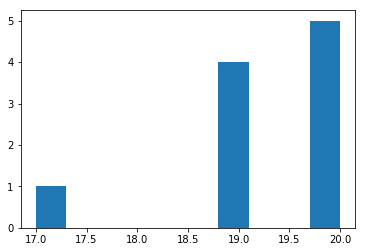

In [363]:
m = 'LTGL ($\ell_2^2$)'
plt.hist([np.linalg.matrix_rank(r) for r in mm.loc[m].estimator.latent_], label=m)

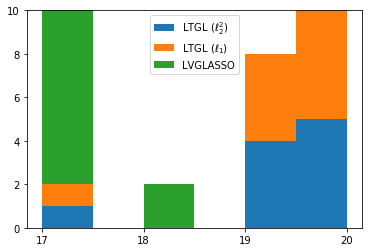

In [382]:
methods = ['LTGL ($\ell_2^2$)', 'LTGL ($\ell_1$)', 'LVGLASSO']
l = []
for m in methods:
    if m != 'LVGLASSO':
        l.append([np.linalg.matrix_rank(r) for r in mm.loc[m].estimator.latent_])
    else:
        l.append([np.linalg.matrix_rank(r) for r in mm.loc[m].estimator.L])
        
plt.hist(l, bins=6, label=methods, stacked=1, align='mid')
plt.xticks([17,18,19,20])
plt.legend()

ValueError: incompatible sizes: argument 'height' must be length 6 or scalar

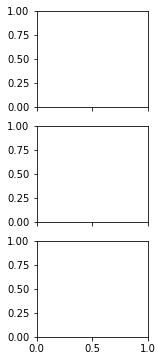

In [438]:
methods = ['LTGL ($\ell_2^2$)', 'LTGL ($\ell_1$)', 'LVGLASSO']
colors=['C1', 'C2', 'C3']
l = []
binwidth=1
bins = np.arange(16,21) - 0.5
f, ax = plt.subplots(3,1, sharex=True, figsize=(2,6))
for i, m in enumerate(methods):
    if m != 'LVGLASSO':  
        ranks = [np.linalg.matrix_rank(r) for r in mm.loc[m].estimator.latent_]
        ax[i].bar([16,17,18,19,20,21], ranks, bins=6, label=m, color=colors[i], normed=True)
        #ax[i].set_xlim()
    else:
        ranks = [np.linalg.matrix_rank(r) for r in mm.loc[m].estimator.L]
        ax[i].hist(ranks, bins=bins, label=m, color=colors[i], normed=True)
        
    
    ax[i].legend()
    #ax[i].set_ylim(-.5, 5.5)
#plt.xticks([17,18,19,20])

f.tight_layout()

In [429]:
print ([np.linalg.matrix_rank(g) for g in res_c['estimator'].L])
print ([np.linalg.matrix_rank(g) for g in res_l['estimator'].latent_])

[18, 17, 17, 17, 17, 17, 17, 18, 17, 17]
[19, 20, 20, 20, 20, 19, 19, 20, 19, 17]


In [337]:
# mm.loc[idx[:], idx[['f1', 'accuracy', 'mean_rank_error']]].astype(float).round(3).to_latex(
#     "table_setting_1_5feb.tex", na_rep='-', escape=False)

In [338]:
utils.save_pickle(data, "data_setting_1.pkl")

In [163]:
dff.T.to_latex("arr.tex", float_format='%.2f', na_rep='-')